Building the bathymetry tutorial starting from the SlideRule Grand Mesa demo. Currently in progress.

Jonathan Markel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sliderule import sliderule, icesat2, earthdata

In [2]:
url = "slideruleearth.io"
icesat2.init(url, verbose=False)
asset = "icesat2"

Using the Shark Bay track that can be found on OpenAltimetry [here](https://openaltimetry.org/data/icesat2/elevation?minx=112.75162305009795&miny=-26.877032522887525&maxx=114.30196711853347&maxy=-24.38549436684328&zoom_level=8&beams=1,2,3,4,5,6&tracks=544&date=2022-04-27&product=ATL08&mapType=geographic&tab=photon).

Note you may need to log in to EarthData and select 'view all photons' to see bathymetry returns in OpenAltimetry.

In [3]:
# create bbox from widget

In [4]:
from ipyleaflet import Map, DrawControl, basemaps

# default bounding box
bbox_coords = []

def handle_draw(target, action, geo_json):
    if action == 'created':
        coords = geo_json['geometry']['coordinates'][0]
        bbox_coords.append(coords)

# setting up the map
m = Map(basemap=basemaps.Esri.WorldImagery, 
        center=(-26, 113.5), # Shark Bay, Australia
        zoom=9, 
        scroll_wheel_zoom=True)

# simplifying user options - can be used to enable polygons, line drawings, etc
dc = DrawControl(circlemarker={}, polyline={}, polygon={})

dc.rectangle = {
    "shapeOptions": {
        "fillColor": "#bf5700",
        "color": "#bf5700",
        "fillOpacity": 0.5
    }
}
dc.on_draw(handle_draw)
m.add_control(dc)
m

Map(center=[-26, 113.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [5]:
# default bounding box for demo
bbox_coords = [[[113, -26.1],
  [113, -25.6],
  [114, -25.6],
  [114, -26.1],
  [113, -26.1]]]

In [6]:
display(bbox_coords)

[[[113, -26.1], [113, -25.6], [114, -25.6], [114, -26.1], [113, -26.1]]]

In [7]:
from shapely import Polygon
import geopandas as gpd

polygon = Polygon(bbox_coords[0])

bbox_gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")

utm_crs = bbox_gdf.estimate_utm_crs()

display(utm_crs) # full crs info
# print(utm_crs) # EPSG:X

<Projected CRS: EPSG:32749>
Name: WGS 84 / UTM zone 49S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°E and 114°E, southern hemisphere between 80°S and equator, onshore and offshore. Australia. Indonesia.
- bounds: (108.0, -80.0, 114.0, 0.0)
Coordinate Operation:
- name: UTM zone 49S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# date of track (pre-identified via openaltimetry), 
target_date = '2022-04-27'
day_window = 1 # days on either side to query

# Specific RGT to analyze
target_rgt = 544

In [9]:
from datetime import datetime, timedelta

In [10]:
%%time

# build sliderule parameters for ATL03 subsetting request
# SRT_LAND = 0
# SRT_OCEAN = 1
# SRT_SEA_ICE = 2
# SRT_LAND_ICE = 3
# SRT_INLAND_WATER = 4

parms = {
    # processing parameters
    "srt": icesat2.SRT_LAND,
    "len": 20,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True, 
    # all photons
    "cnf": -2, 
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
    
    # extra fields from ATL03 gtxx/geolocation or gtxx/geophys_corr channels
    "atl03_geo_fields": ["ref_azimuth", "ref_elev"],
    
    # extra fields via ATL03 "gtxx/heights" (see atl03 data dictionary)
    "atl03_ph_fields": [] # 
}

# ICESat-2 data release
release = '006'

# region of interest
# reformatting as dict - necessary? tbd
coords_arr = np.array(bbox_coords[0])

poly = []
for point in coords_arr:
    poly.append({
        'lat': point[1],
        'lon': point[0]
    })
    
# time bounds for CMR query

# Convert to datetime
target_dt = datetime.strptime(target_date, '%Y-%m-%d')

# Calculate dates before and after 
time_start = target_dt - timedelta(days=day_window)
time_end = target_dt + timedelta(days=day_window)

# Convert back to string
time_start = time_start.strftime('%Y-%m-%d')  
time_end = time_end.strftime('%Y-%m-%d')

# find granule for each region of interest
granules_list = earthdata.cmr(short_name='ATL03', polygon=poly, time_start=time_start, time_end=time_end, version=release)

# create an empty geodataframe
parms["poly"] = poly
gdf = icesat2.atl03sp(parms, asset=asset, version=release, resources=granules_list)

CPU times: user 19.8 s, sys: 595 ms, total: 20.4 s
Wall time: 24.6 s


In [11]:
gdf.columns

Index(['rgt', 'sc_orient', 'background_rate', 'segment_dist', 'track',
       'segment_id', 'solar_elevation', 'cycle', 'atl03_cnf', 'relief',
       'landcover', 'height', 'snowcover', 'atl08_class', 'distance',
       'quality_ph', 'yapc_score', 'ref_azimuth', 'ref_elev', 'pair',
       'geometry', 'spot'],
      dtype='object')

In [12]:
gdf.head()

,rgt,sc_orient,background_rate,segment_dist,track,segment_id,solar_elevation,cycle,atl03_cnf,relief,...,snowcover,atl08_class,distance,quality_ph,yapc_score,ref_azimuth,ref_elev,pair,geometry,spot
time,,,,,,,,,,,,,,,,,,,,,
2022-04-27 18:24:23.542012416,544,0,27298.070926,3.724124e+07,3,1862284,-59.212006,15,4,0.0,...,255,1,-9.509996,0,253,1.684563,1.547997,0,POINT (113.56022 -26.09995),5
2022-04-27 18:24:23.542012416,544,0,27298.070926,3.724124e+07,3,1862284,-59.212006,15,4,0.0,...,255,1,-9.508061,0,242,1.684563,1.547997,0,POINT (113.56022 -26.09995),5
2022-04-27 18:24:23.542012416,544,0,27298.070926,3.724124e+07,3,1862284,-59.212006,15,4,0.0,...,255,1,-9.509996,0,253,1.684563,1.547997,0,POINT (113.56022 -26.09995),5
2022-04-27 18:24:23.542012416,544,0,27298.070926,3.724124e+07,3,1862284,-59.212006,15,4,0.0,...,255,1,-9.509996,0,253,1.684563,1.547997,0,POINT (113.56022 -26.09995),5
2022-04-27 18:24:23.542112256,544,0,27298.070926,3.724124e+07,3,1862284,-59.212006,15,4,0.0,...,255,1,-8.802989,0,249,1.684563,1.547997,0,POINT (113.56022 -26.09994),5


### Reduce GeoDataFrame to plot a single beam
- Convert coordinate reference system to compound projection

In [13]:
def reduce_dataframe(gdf, RGT=None, GT=None, track=None, pair=None, cycle=None, beam='', crs=4326):
    # convert coordinate reference system
    D3 = gdf.to_crs(crs)
    # reduce to reference ground track
    if RGT is not None:
        D3 = D3[D3["rgt"] == RGT]
        
    # reduce to ground track (gt[123][lr]), track ([123]), or pair (l=0, r=1) 
    gtlookup = {icesat2.GT1L: 1, icesat2.GT1R: 1, icesat2.GT2L: 2, icesat2.GT2R: 2, icesat2.GT3L: 3, icesat2.GT3R: 3}
    pairlookup = {icesat2.GT1L: 0, icesat2.GT1R: 1, icesat2.GT2L: 0, icesat2.GT2R: 1, icesat2.GT3L: 0, icesat2.GT3R: 1}
    if GT is not None:
        D3 = D3[(D3["track"] == gtlookup[GT]) & (D3["pair"] == pairlookup[GT])]
    if track is not None:
        D3 = D3[D3["track"] == track]
    if pair is not None:
        D3 = D3[D3["pair"] == pair]
        
    # reduce to weak or strong beams
    # tested on cycle 11, where the strong beam in the pair matches the spacecraft orientation.
    # Need to check on other cycles
    if (beam == 'strong'):
        D3 = D3[D3['sc_orient'] == D3['pair']]
    elif (beam == 'weak'):
        D3 = D3[D3['sc_orient'] != D3['pair']]
        
    # reduce to cycle
    if cycle is not None:
        D3 = D3[D3["cycle"] == cycle]
    # otherwise, return both beams
    return D3

In [14]:
beam_type = 'strong'
project_srs = f"{str(utm_crs)}+EPSG:3855" # best estimate UTM zone + EGM08 geoid
D3 = reduce_dataframe(gdf, 
                      RGT=target_rgt, 
                      track=1, 
                      beam='strong', 
                      crs=project_srs)

### Compute photon along-track distance from start of data

In [15]:
d0=np.min(D3['segment_dist'])
D3['along_track_meters'] = D3['segment_dist']+D3['distance']-d0

### Visualize on interactive map

In [16]:
from ipyleaflet import Polyline

In [17]:
D3_wgs = D3.to_crs('EPSG:4326')
ph_loc_list = list(zip(D3_wgs['geometry'].x.values, D3_wgs['geometry'].y.values))

In [18]:
ground_track = Polyline(locations=ph_loc_list, 
                         color='red', weight=3)

m.add_layer(ground_track)
m

Map(center=[-26, 113.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

### Plot the ATL08 classifications

In [20]:
ylim = [-100, 50]

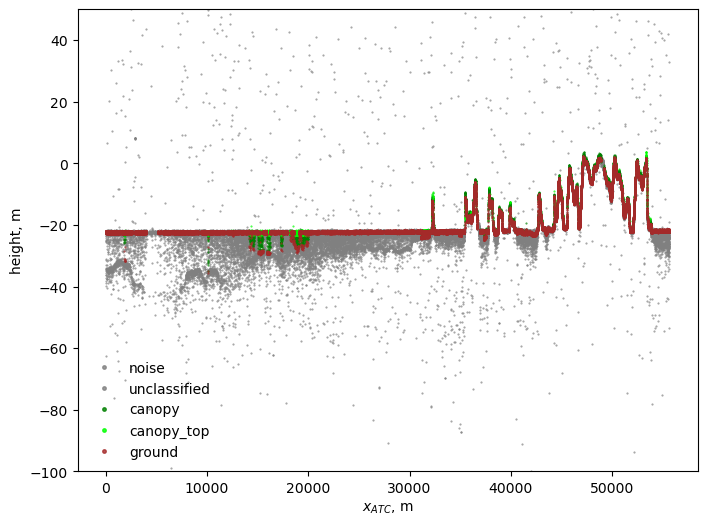

In [21]:
plt.figure(figsize=[8,6])

colors={0:['gray', 'noise'], 
        4:['gray','unclassified'],  
        2:['green','canopy'], 
        3:['lime', 'canopy_top'], 
        1:['brown', 'ground']}

for class_val, color_name in colors.items():
    ii=D3['atl08_class']==class_val
    plt.plot(D3['along_track_meters'][ii], D3['height'][ii],'o', 
         markersize=.5, alpha=0.8, color=color_name[0], label=color_name[1])
    
hl=plt.legend(loc=3, frameon=False, markerscale=5)

plt.gca().set_ylim(ylim)

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');

### Plot the YAPC classifications

In [25]:
# plt.figure(figsize=[10,6])

# ii=np.argsort(D3['yapc_score'])

# plt.scatter(D3['along_track_meters'],
#     D3['height'][ii], 2, c=D3['yapc_score'][ii],
#     vmin=10, vmax=255, cmap='plasma_r')

# plt.colorbar(label='YAPC score')

# plt.gca().set_ylim(ylim)

# plt.ylabel('height, m')

# plt.xlabel('$x_{ATC}$, m');

### Plot the ATL03 signal confidence values

In [23]:
# TBD